In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from datetime import datetime
from utils import create_datetime_column
from model import TrafficAnalyzer, ARIMAModel, SARIMAModel
from dl_model import TimeSeriesDataset, DenseNN, LSTM, train_model

## Build Dataset

In [2]:
# Read the CSV file from the dataset folder
file_path = 'dataset/TrafficTwoMonth.csv'
df = pd.read_csv(file_path)

# Create datetime column
df = create_datetime_column(df)
df.drop(['Time', 'Date', 'Day of the week'], axis=1, inplace=True)

## Análisis

In [ ]:
analyser = TrafficAnalyzer(df)

message = analyser.check_stationarity(df['Total'])
print(message)

analyser.plot_time_series(
    figsize=(10, 6), 
    columns=['Total', 'CarCount', 'BikeCount'], 
    xticks_step=96, 
    start_pct=20, 
    end_pct=30)

analyser.plot_autocorrelation(df['Total'], lags=20)

## ARIMA

### Introducción teórica

El modelo ARIMA (AutoRegressive Integrated Moving Average) es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se expresa matemáticamente como ARIMA(p,d,q) donde:

- p: orden de la parte autorregresiva (AR)
- d: grado de diferenciación necesario para alcanzar la estacionariedad
- q: orden de la parte de media móvil (MA)

La ecuación general del modelo ARIMA es:

$$(1-\sum_{i=1}^p \phi_i L^i)(1-L)^d y_t = (1+\sum_{i=1}^q \theta_i L^i)\epsilon_t$$

Donde:
- $L$ es el operador de retardo
- $\phi_i$ son los parámetros del modelo AR
- $\theta_i$ son los parámetros del modelo MA
- $\epsilon_t$ es el término de error

### Secuencia de Modelado

1. Primero creamos un modelo ARIMA usando los datos de tráfico total
2. Optimizamos los parámetros del modelo probando diferentes combinaciones de p y q (manteniendo d=0)
3. Ajustamos el modelo con los mejores parámetros encontrados
4. Realizamos predicciones usando rolling forecast con una ventana de entrenamiento del 98% de los datos
5. Visualizamos los resultados comparando las predicciones con los datos reales

In [9]:
p_range = range(1, 10)
q_range = range(1, 10)
d = 0

In [10]:
# Optimización
arima_model = ARIMAModel(df['Total'])
arima_model.optimize(p_range, d, q_range)
arima_model.fit()

Optimizando ARIMA:   0%|          | 0/81 [00:00<?, ?it/s]


Resumen de optimización:
Ajustes exitosos: 81/81 (100.0%)

Mejor modelo: ARIMA(9,0,9)
AIC: 56873.80
BIC: 57007.60


In [11]:
# Predicción
train_size = int(len(df) * 0.98)
window = 1
predictions_arima = arima_model.rolling_forecast(train_size, window)

Rolling forecast ARIMA:   0%|          | 0/120 [00:00<?, ?it/s]

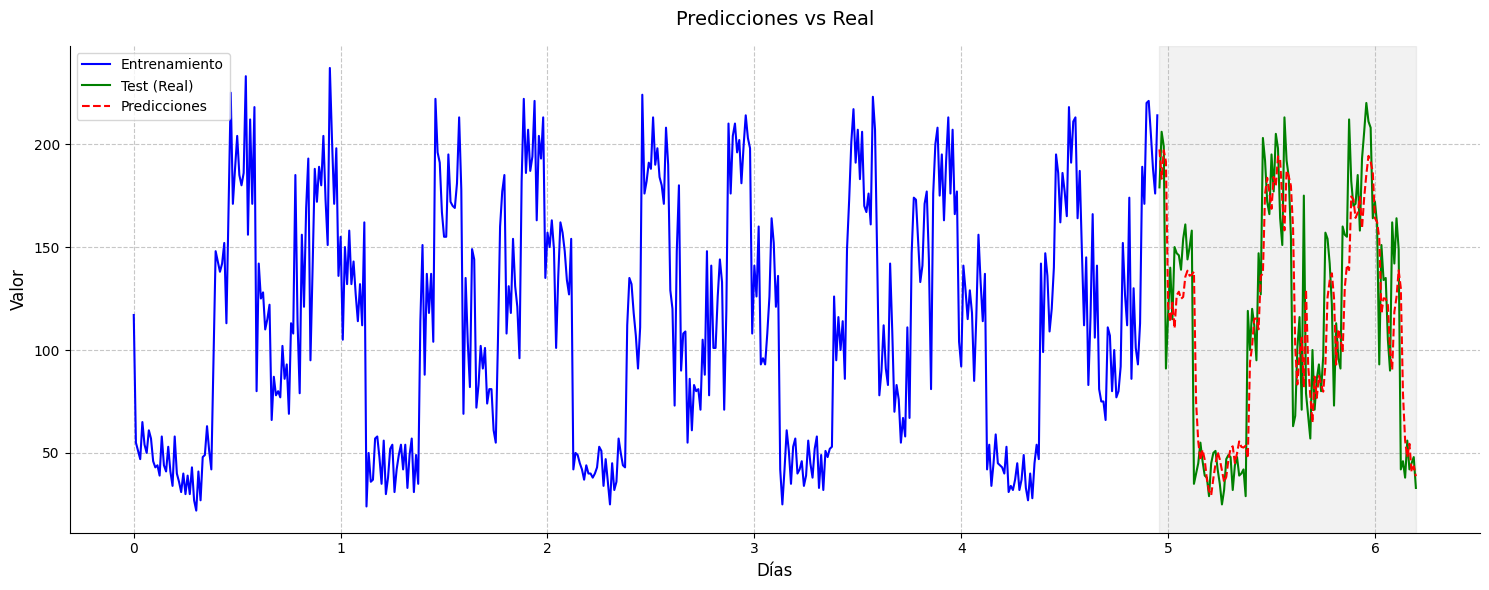

In [12]:
# Visualización
start_i = int(len(df) * 0.90)
end_i = int(len(df) * 0.98)
arima_model.plot_predictions(
    train_data=df['Total'].values[start_i:end_i],
    test_data=df['Total'].values[end_i:],
    predictions=predictions_arima
)

In [13]:
# Métricas
test_data = np.array(df['Total'].iloc[int(len(df) * 0.98):])
predictions_arima = np.array(predictions_arima)
arima_model.print_metrics(test_data, predictions_arima)


Métricas de Error:
------------------------------
RMSE: 31.8985
MAE:  22.7518
MAPE: 26.25%


## SARIMA

### Introducción teórica

El modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) es una extensión del modelo ARIMA que incorpora la estacionalidad. Se expresa matemáticamente como SARIMA(p,d,q)(P,D,Q,m) donde:

- p: orden de la parte autorregresiva (AR)
- d: grado de diferenciación necesario para alcanzar la estacionariedad
- q: orden de la parte de media móvil (MA)
- P: orden de la parte autorregresiva estacional (SAR)
- D: grado de diferenciación estacional
- Q: orden de la parte de media móvil estacional (SMA)
- m: período estacional

La ecuación general del modelo SARIMA es:

$\Phi_P(L^m)\phi_p(L)(1-L^m)^D(1-L)^dy_t = \Theta_Q(L^m)\theta_q(L)\epsilon_t$

Donde:
- $L$ es el operador de retardo
- $\phi_p(L)$ es el operador AR no estacional
- $\Phi_P(L^m)$ es el operador AR estacional
- $\theta_q(L)$ es el operador MA no estacional
- $\Theta_Q(L^m)$ es el operador MA estacional
- $\epsilon_t$ es el término de error

### Secuencia de Modelado

1. Primero creamos un modelo SARIMA usando los datos de tráfico total
2. Optimizamos los parámetros del modelo probando diferentes combinaciones de p, d, q y P, D, Q (con m=96)
3. Ajustamos el modelo con los mejores parámetros encontrados
4. Realizamos predicciones usando rolling forecast con una ventana de entrenamiento del 95% de los datos
5. Visualizamos los resultados comparando las predicciones con los datos reales


In [3]:
p_range = range(1, 2)
q_range = range(1, 2)
P_range = range(1, 3)
Q_range = range(1, 3)
m = 12
d = 0
D = 1

In [ ]:
# Optimización
sarima_model = SARIMAModel(df['Total'])
sarima_model.optimize(p_range, d, q_range, P_range, D, Q_range, m)
sarima_model.fit(order=sarima_model.best_order, seasonal_order=sarima_model.best_seasonal_order)

In [ ]:
# Predicción
train_size = int(len(df) * 0.98)
window = 2
predictions_sarima = sarima_model.rolling_forecast(train_size, window)

In [ ]:
# Visualización
start_i = int(len(df) * 0.90)
end_i = int(len(df) * 0.98)
sarima_model.plot_predictions(
    train_data=df['Total'].values[start_i:end_i],
    test_data=df['Total'].values[end_i:],
    predictions=predictions_sarima
)

In [ ]:
# Métricas
test_data = np.array(df['Total'].iloc[int(len(df) * 0.98):])
predictions_sarima = np.array(predictions_sarima)
sarima_model.print_metrics(test_data, predictions_sarima)

In [ ]:
order = (1, 0, 1)
seasonal_order = (2, 1, 2, 24)
sarima_model.fit(order=order, seasonal_order=seasonal_order)

# Redes Neuronales Densas para Series Temporales

Las redes neuronales densas son una técnica de deep learning que puede aplicarse a la predicción de series temporales. A diferencia de los modelos estadísticos tradicionales como SARIMA, las redes neuronales pueden aprender patrones complejos y no lineales en los datos.

## Fundamentos

- Las redes densas consisten en capas de neuronas totalmente conectadas
- Cada neurona recibe inputs de todas las neuronas de la capa anterior
- Se aplican transformaciones no lineales (funciones de activación) 
- La red aprende los pesos de las conexiones durante el entrenamiento
- Se usa backpropagation y descenso del gradiente para optimizar

## Preparación de datos para series temporales

Para usar redes neuronales con series temporales:

1. Se crean ventanas deslizantes de datos secuenciales
2. Cada ventana tiene:
   - Input: Valores históricos (ej: últimas 24 horas)
   - Label: Valores futuros a predecir (ej: próxima hora) 
3. Los datos se dividen en batches para el entrenamiento
4. Se normalizan los valores para mejorar el aprendizaje

## Aplicación al tráfico vehicular

En nuestro caso:

- Usaremos ventanas de 24 horas como input
- Predeciremos la siguiente hora de tráfico
- Los datos se dividirán en train (70%), validation (15%) y test (15%)
- Se normalizarán los conteos de vehículos
- La arquitectura tendrá múltiples capas densas con ReLU
- Se optimizará con Adam y MSE como función de pérdida


In [3]:
data = df['Total'].to_numpy()
ts_dataset = TimeSeriesDataset(data, input_width=96, label_width=1)
ts_dataset.split_data(train_pct=0.8, val_pct=0.1)
ts_dataset.create_windows()
ts_dataset.create_dataloaders(batch_size=16)


División de datos:
Train: 4761 muestras (80.0%)
Validation: 595 muestras (10.0%)
Test: 596 muestras (10.0%)

Ventanas creadas:
Train: 4665 ventanas
Validation: 499 ventanas
Test: 500 ventanas

Tamaño de cada ventana:
Input: 96 pasos
Label: 1 pasos

Dataloaders creados:
Train: 4665 muestras, 292 batches
Validation: 499 muestras, 32 batches
Test: 500 muestras, 32 batches

Configuración:
Batch size: 16
Workers: 0
Shuffle: True (train), False (val/test)


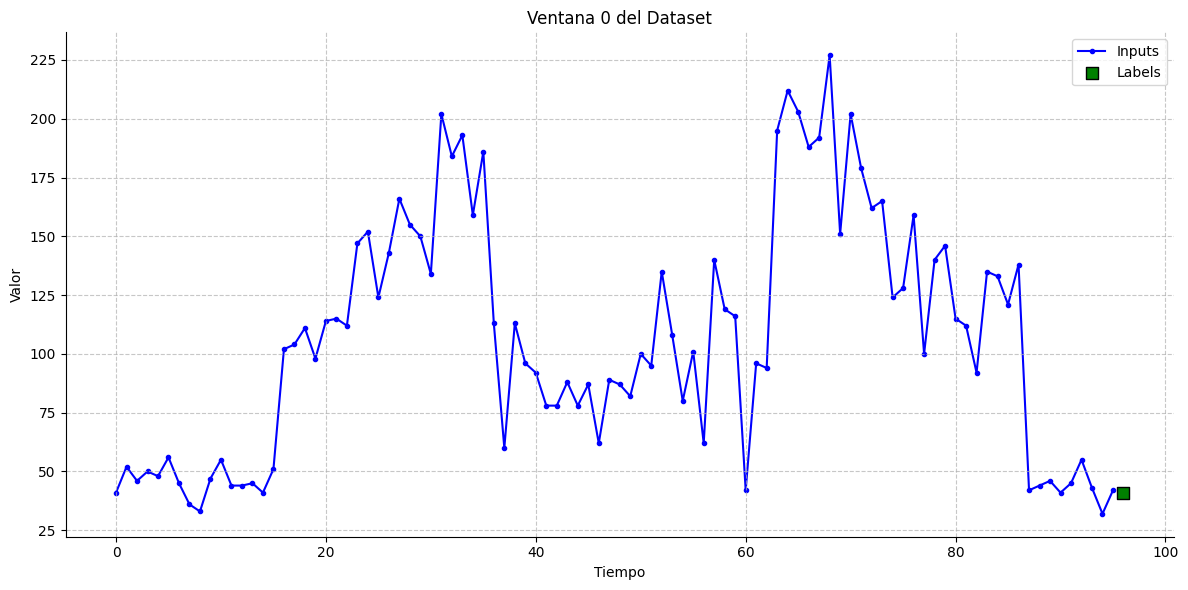

In [14]:
ts_dataset.plot_window()

In [4]:
# Detectar si hay GPU disponible y configurar el dispositivo
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [15]:
# Definir modelo, optimizador y función de pérdida
model = DenseNN(input_size=96, hidden_sizes=[128, 64, 32], output_size=1)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.00001)
epochs = 500

In [ ]:
train_losses, val_losses = train_model(model, ts_dataset.train_loader, ts_dataset.val_loader, 
                                       optimizer, epochs, print_every=50)

Epoch 50/500:Loss (Train/Val): 335.2742/562.0508
Epoch 100/500:Loss (Train/Val): 204.7047/626.7143
Epoch 150/500:Loss (Train/Val): 119.3618/670.4022
Epoch 200/500:Loss (Train/Val): 81.2119/712.4191


In [ ]:
# Graficar pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('losses_dense.png')

In [5]:
# Definir modelo, optimizador y función de pérdida
model_lstm = LSTM(input_size=96, hidden_size=128, num_layers=1, output_size=1, device=device)
optimizer = torch.optim.RMSprop(model_lstm.parameters(), lr=0.0001, weight_decay=0.00001)
epochs = 500

In [6]:
train_losses_lstm, val_losses_lstm = train_model(model_lstm, ts_dataset.train_loader, 
                                                 ts_dataset.val_loader, optimizer, epochs, print_every=50)

Epoch 50/500:Loss (Train/Val): 1137.7198/1702.9472
Epoch 100/500:Loss (Train/Val): 496.0304/723.6929
Epoch 150/500:Loss (Train/Val): 425.5636/616.3630
Epoch 200/500:Loss (Train/Val): 357.3884/573.3129
Epoch 250/500:Loss (Train/Val): 297.6958/550.5679
Epoch 300/500:Loss (Train/Val): 265.7670/550.6640
Epoch 350/500:Loss (Train/Val): 233.8002/530.7680
Epoch 400/500:Loss (Train/Val): 192.9754/556.8474
Epoch 450/500:Loss (Train/Val): 164.7607/525.3468
Epoch 500/500:Loss (Train/Val): 136.9745/542.7773


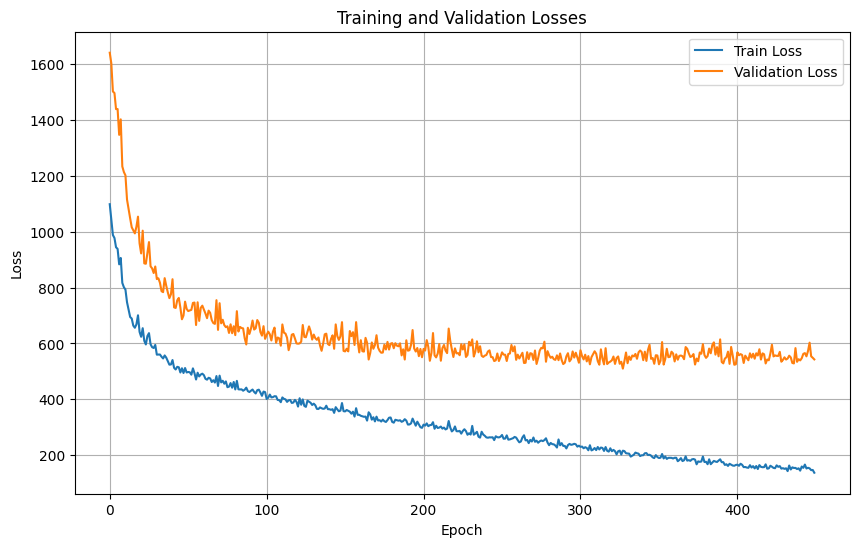

In [ ]:
# Graficar pérdidas
plt.figure(figsize=(10, 6))
plt.plot(train_losses_lstm[50:], label='Train Loss')
plt.plot(val_losses_lstm[50:], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('losses_lstm.png')